# **Практическое задание к курсу**

### 1. Обучите нейронную сеть любой архитектуры которой не было на курсе, либо обучите нейронную сеть разобранной архитектуры, но на том датасете, которого не было на уроках. Сделайте анализ, того, что вам помогло в улучшения работы нейронной сети.

# Variational AutoEncoder

(https://twitter.com/fchollet)<br>
Convolutional Variational AutoEncoder (VAE) trained on fashion MNIST.

## Setup


In [1]:
import numpy as np
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers


## Строим слой семплирования sampling layer


In [2]:

class Sampling(layers.Layer):
    """Uses (z_mean, z_log_var) to sample z, the vector encoding a picture."""

    def call(self, inputs):
        z_mean, z_log_var = inputs
        batch = tf.shape(z_mean)[0]
        dim = tf.shape(z_mean)[1]
        epsilon = tf.keras.backend.random_normal(shape=(batch, dim))
        return z_mean + tf.exp(0.5 * z_log_var) * epsilon



## Строим энкодер encoder


In [3]:
latent_dim = 2

encoder_inputs = keras.Input(shape=(28, 28, 1))
x = layers.Conv2D(32, 3, activation="relu", strides=2, padding="same")(encoder_inputs)
x = layers.Conv2D(64, 3, activation="relu", strides=2, padding="same")(x)
x = layers.Flatten()(x)
x = layers.Dense(16, activation="relu")(x)
z_mean = layers.Dense(latent_dim, name="z_mean")(x)
z_log_var = layers.Dense(latent_dim, name="z_log_var")(x)
z = Sampling()([z_mean, z_log_var])
encoder = keras.Model(encoder_inputs, [z_mean, z_log_var, z], name="encoder")
encoder.summary()


Model: "encoder"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 28, 28, 1)]  0                                            
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 14, 14, 32)   320         input_1[0][0]                    
__________________________________________________________________________________________________
conv2d_1 (Conv2D)               (None, 7, 7, 64)     18496       conv2d[0][0]                     
__________________________________________________________________________________________________
flatten (Flatten)               (None, 3136)         0           conv2d_1[0][0]                   
____________________________________________________________________________________________

## Строим свой decoder


In [4]:
latent_inputs = keras.Input(shape=(latent_dim,))
x = layers.Dense(7 * 7 * 64, activation="relu")(latent_inputs)
x = layers.Reshape((7, 7, 64))(x)
x = layers.Conv2DTranspose(64, 3, activation="relu", strides=2, padding="same")(x)
x = layers.Conv2DTranspose(32, 3, activation="relu", strides=2, padding="same")(x)
decoder_outputs = layers.Conv2DTranspose(1, 3, activation="sigmoid", padding="same")(x)
decoder = keras.Model(latent_inputs, decoder_outputs, name="decoder")
decoder.summary()


Model: "decoder"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, 2)]               0         
_________________________________________________________________
dense_1 (Dense)              (None, 3136)              9408      
_________________________________________________________________
reshape (Reshape)            (None, 7, 7, 64)          0         
_________________________________________________________________
conv2d_transpose (Conv2DTran (None, 14, 14, 64)        36928     
_________________________________________________________________
conv2d_transpose_1 (Conv2DTr (None, 28, 28, 32)        18464     
_________________________________________________________________
conv2d_transpose_2 (Conv2DTr (None, 28, 28, 1)         289       
Total params: 65,089
Trainable params: 65,089
Non-trainable params: 0
_______________________________________________________

## Создаем класс модель по `Model` с особым шагом *обучения* `train_step`


In [5]:

class VAE(keras.Model):
    def __init__(self, encoder, decoder, **kwargs):
        super(VAE, self).__init__(**kwargs)
        self.encoder = encoder
        self.decoder = decoder

    def train_step(self, data):
        if isinstance(data, tuple):
            data = data[0]
        with tf.GradientTape() as tape:
            z_mean, z_log_var, z = encoder(data)
            reconstruction = decoder(z)
            reconstruction_loss = tf.reduce_mean(
                keras.losses.binary_crossentropy(data, reconstruction)
            )
            reconstruction_loss *= 28 * 28
            kl_loss = 1 + z_log_var - tf.square(z_mean) - tf.exp(z_log_var)
            kl_loss = tf.reduce_mean(kl_loss)
            kl_loss *= -0.5
            total_loss = reconstruction_loss + kl_loss
        grads = tape.gradient(total_loss, self.trainable_weights)
        self.optimizer.apply_gradients(zip(grads, self.trainable_weights))
        return {
            "loss": total_loss,
            "reconstruction_loss": reconstruction_loss,
            "kl_loss": kl_loss,
        }



## Учим VAE


In [6]:
(x_train, _), (x_test, _) = keras.datasets.fashion_mnist.load_data()
mnist_images = np.concatenate([x_train, x_test], axis=0)
mnist_images = np.expand_dims(mnist_images, -1).astype("float32") / 255

vae = VAE(encoder, decoder)
vae.compile(optimizer=keras.optimizers.Adam())
vae.fit(mnist_images, epochs=20, batch_size=128)


Epoch 1/20
547/547 [==============================] - 6s 7ms/step - loss: 329.2605 - reconstruction_loss: 323.5978 - kl_loss: 5.6627
Epoch 2/20
547/547 [==============================] - 4s 7ms/step - loss: 277.8396 - reconstruction_loss: 272.4409 - kl_loss: 5.3987
Epoch 3/20
547/547 [==============================] - 4s 7ms/step - loss: 271.6697 - reconstruction_loss: 266.8769 - kl_loss: 4.7928
Epoch 4/20
547/547 [==============================] - 4s 7ms/step - loss: 269.2399 - reconstruction_loss: 264.6201 - kl_loss: 4.6198
Epoch 5/20
547/547 [==============================] - 4s 7ms/step - loss: 267.6220 - reconstruction_loss: 263.0939 - kl_loss: 4.5281
Epoch 6/20
547/547 [==============================] - 4s 7ms/step - loss: 266.4944 - reconstruction_loss: 262.0146 - kl_loss: 4.4798
Epoch 7/20
547/547 [==============================] - 4s 7ms/step - loss: 265.7334 - reconstruction_loss: 261.2775 - kl_loss: 4.4559
Epoch 8/20
547/547 [==============================] - 4s 7ms/step - l

In [7]:
vae.fit(mnist_images, epochs=20, batch_size=128)

Epoch 1/20
547/547 [==============================] - 4s 7ms/step - loss: 259.9391 - reconstruction_loss: 255.9916 - kl_loss: 3.9475
Epoch 2/20
547/547 [==============================] - 4s 7ms/step - loss: 259.8810 - reconstruction_loss: 255.9637 - kl_loss: 3.9173
Epoch 3/20
547/547 [==============================] - 4s 7ms/step - loss: 259.5025 - reconstruction_loss: 255.6019 - kl_loss: 3.9006
Epoch 4/20
547/547 [==============================] - 4s 7ms/step - loss: 259.4090 - reconstruction_loss: 255.5299 - kl_loss: 3.8791
Epoch 5/20
547/547 [==============================] - 4s 7ms/step - loss: 259.1561 - reconstruction_loss: 255.2980 - kl_loss: 3.8581
Epoch 6/20
547/547 [==============================] - 4s 7ms/step - loss: 258.9855 - reconstruction_loss: 255.1370 - kl_loss: 3.8485
Epoch 7/20
547/547 [==============================] - 4s 7ms/step - loss: 258.8652 - reconstruction_loss: 255.0273 - kl_loss: 3.8378
Epoch 8/20
547/547 [==============================] - 4s 7ms/step - l

## Результат предсказания для предмета


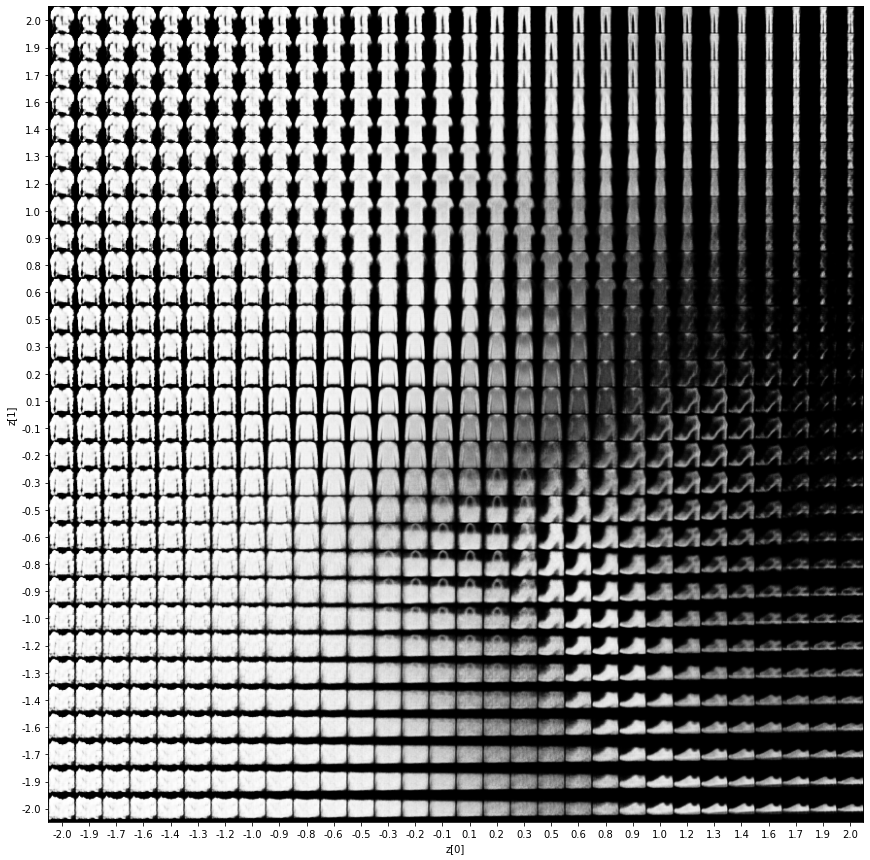

In [8]:
import matplotlib.pyplot as plt


def plot_latent(encoder, decoder):
    # display a n*n 2D manifold of digits
    n = 30
    digit_size = 28
    scale = 2.0
    figsize = 15
    figure = np.zeros((digit_size * n, digit_size * n))
    # linearly spaced coordinates corresponding to the 2D plot
    # of digit classes in the latent space
    grid_x = np.linspace(-scale, scale, n)
    grid_y = np.linspace(-scale, scale, n)[::-1]

    for i, yi in enumerate(grid_y):
        for j, xi in enumerate(grid_x):
            z_sample = np.array([[xi, yi]])
            x_decoded = decoder.predict(z_sample)
            digit = x_decoded[0].reshape(digit_size, digit_size)
            figure[
                i * digit_size : (i + 1) * digit_size,
                j * digit_size : (j + 1) * digit_size,
            ] = digit

    plt.figure(figsize=(figsize, figsize))
    start_range = digit_size // 2
    end_range = n * digit_size + start_range + 1
    pixel_range = np.arange(start_range, end_range, digit_size)
    sample_range_x = np.round(grid_x, 1)
    sample_range_y = np.round(grid_y, 1)
    plt.xticks(pixel_range, sample_range_x)
    plt.yticks(pixel_range, sample_range_y)
    plt.xlabel("z[0]")
    plt.ylabel("z[1]")
    plt.imshow(figure, cmap="Greys_r")
    plt.show()


plot_latent(encoder, decoder)


## Посмотрим на кластеры в скрытом пространстве


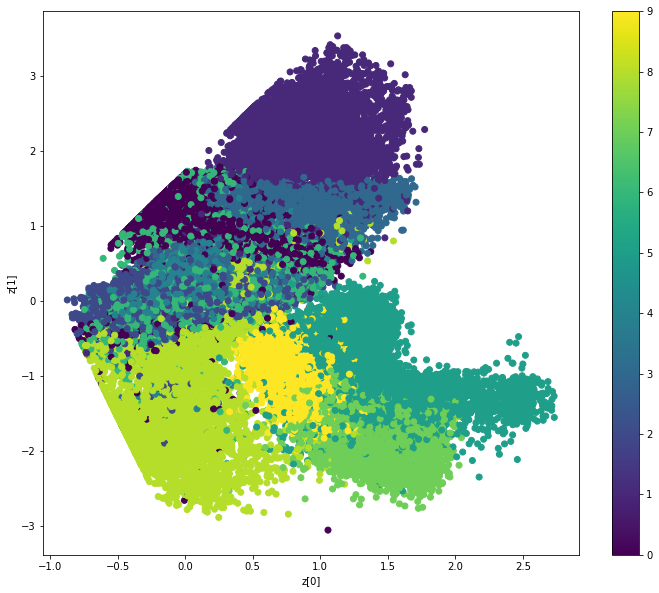

In [9]:

def plot_label_clusters(encoder, data, labels):
    # display a 2D plot of the digit classes in the latent space
    z_mean, _, _ = encoder.predict(data)
    plt.figure(figsize=(12, 10))
    plt.scatter(z_mean[:, 0], z_mean[:, 1], c=labels)
    plt.colorbar()
    plt.xlabel("z[0]")
    plt.ylabel("z[1]")
    plt.show()


(x_train, y_train), _ = keras.datasets.fashion_mnist.load_data()
x_train = np.expand_dims(x_train, -1).astype("float32") / 255

plot_label_clusters(encoder, x_train, y_train)


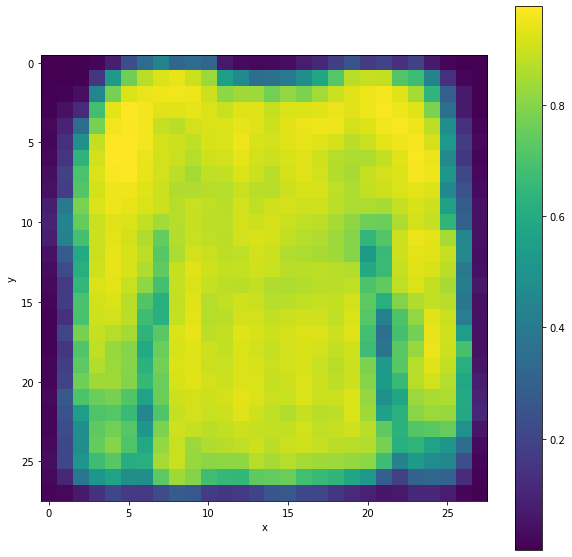

In [15]:

def plot_item_from_decoder(decoder, z, item_size):
    # display a 2D plot of the item classes in the latent space
    
    data = np.array([[z[0], z[1]]])
    item = decoder.predict(data)
    item = item.reshape(item_size, item_size)
    
    plt.figure(figsize=(10, 10))
    plt.imshow(item)
    plt.colorbar()
    plt.xlabel("x")
    plt.ylabel("y")
    plt.show()



plot_item_from_decoder(decoder, [-1,-0.5], 28)

Качество результата увеличивается при увеличении количества эпох. При этом, заметно снижается при уменьшении размера batch. При увеличении размера batch качество повышается, но по кластеры выстраиваются в прямую линию, что свидетельствует о явном переобучении

### 2. Сделайте краткий обзор какой-нибудь научной работы посвященной тому или иному алгоритму нейронных сетей, который не рассматривался на курсе. Проведите анализ: Чем отличается выбранная вами на рассмотрение архитектура нейронной сети от других архитектур? В чем плюсы и минусы данной архитектуры? Какие могут возникнуть трудности при применении данной архитектуры на практике?

#### Архитектура: Self Organizing Maps (SOMs) 
Особенности:
- обучение без учителя
- снижает размерность с многомерного пространства до двухмерного

принцип работы:
- определяет веса для каждого узла
- определяет BMU - узла на карте, вектор веса которого меньше всего отличается от наблюдения (в метрике, задаваемой аналитиком, чаще всего, евклидовой).
- перераспределяет веса в зависимости от расстояния до BMU - чем дальше, тем меньше.

источник: https://www.simplilearn.com/tutorials/deep-learning-tutorial/deep-learning-algorithm